### Opening dicom images through pydicom

In [ ]:
import numpy as np # linear algebra
import pandas as pd
import os
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [ ]:

ds = pydicom.dcmread("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/0005e8e3701dfb1dd93d53e2ff537b6e.dicom")

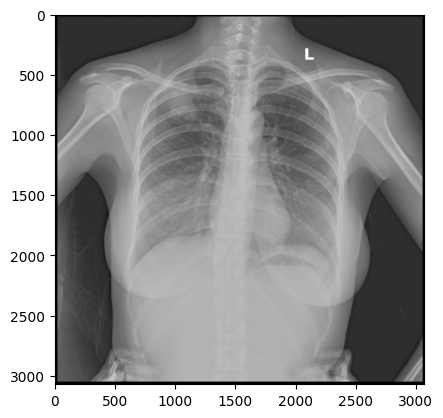

In [ ]:
plt.imshow(ds.pixel_array, cmap = plt.cm.gray)
plt.show()

### YOLO cannot be trained on dicom images so converting Dicom to jpg and comparing the normalization methods

Original range: 0.0 to 16383.0
Original dtype: float64
Image shape: (3072, 3072)


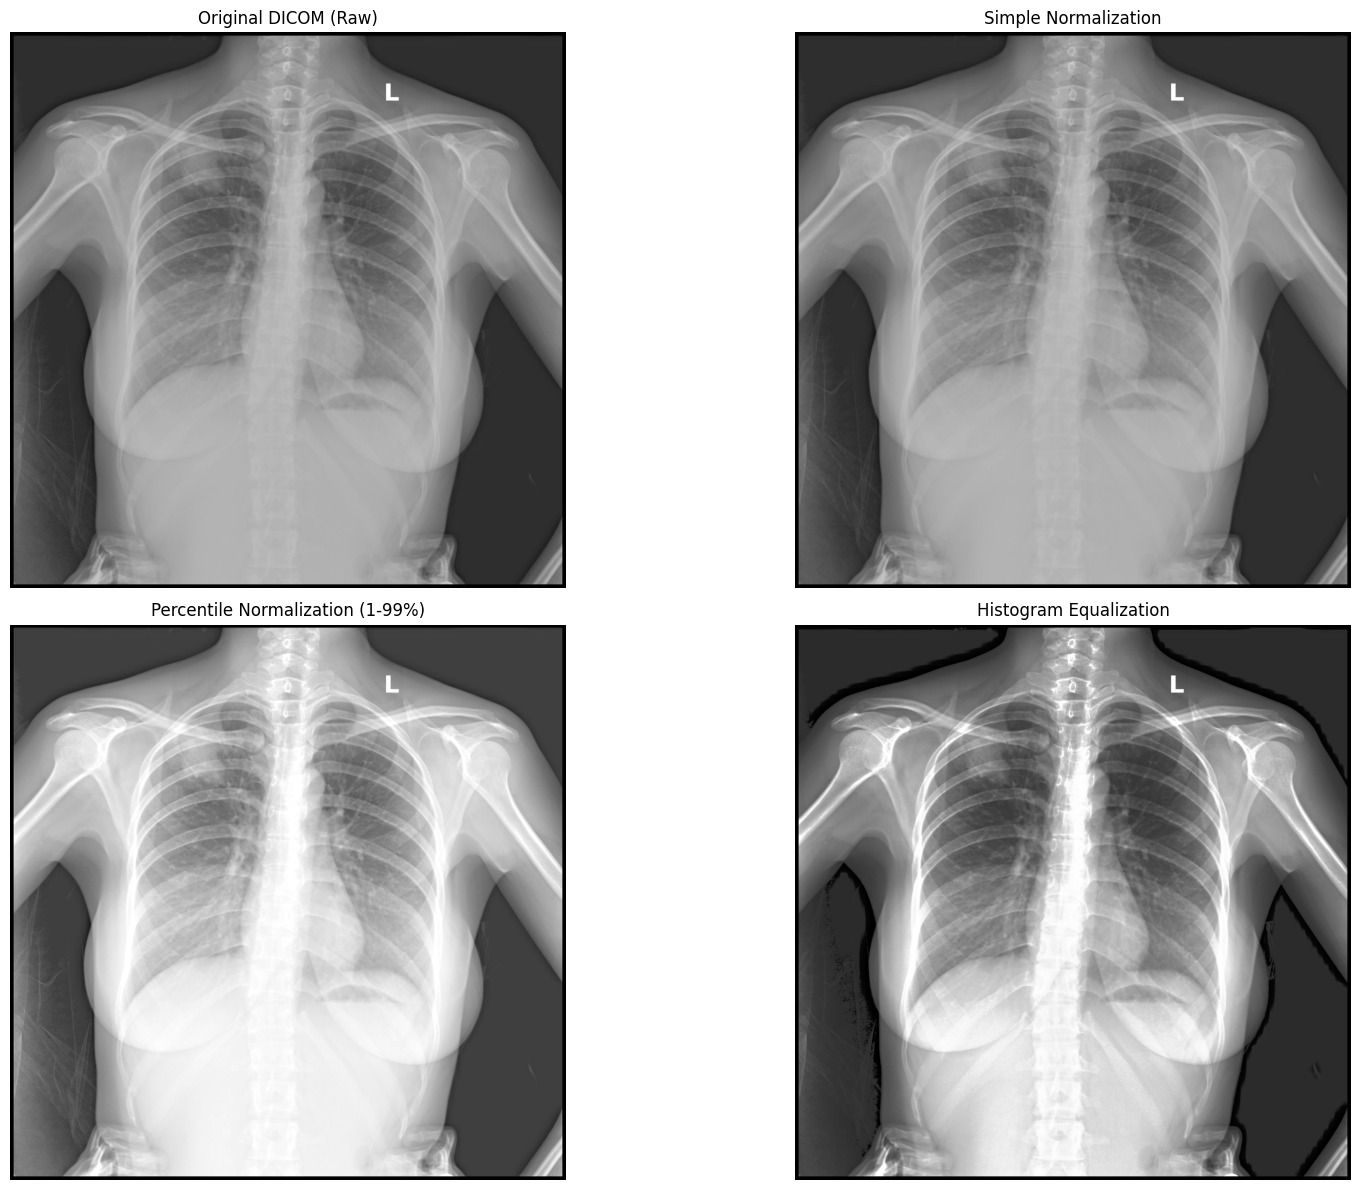

In [85]:
def dicom_conversion(dicom_path):
    # Load DICOM
    ds = pydicom.dcmread(dicom_path)
    img = ds.pixel_array.astype(float)
    
    # Check original image properties
    print(f"Original range: {img.min()} to {img.max()}")
    print(f"Original dtype: {img.dtype}")
    print(f"Image shape: {img.shape}")
    
    # Method 1: Simple normalization (often fails)
    simple_norm = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
    
    # Method 2: Percentile-based normalization (usually better)
    p1, p99 = np.percentile(img, (1, 99))  # Remove outliers
    percentile_norm = np.clip((img - p1) / (p99 - p1) * 255, 0, 255).astype(np.uint8)
    
    # Method 3: Histogram equalization
    from skimage import exposure
    hist_eq = exposure.equalize_hist(img) * 255
    hist_eq = hist_eq.astype(np.uint8)
    
    # Compare all methods
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Original DICOM
    axes[0,0].imshow(img, cmap='gray')
    axes[0,0].set_title('Original DICOM (Raw)')
    
    # Simple normalization
    axes[0,1].imshow(simple_norm, cmap='gray')
    axes[0,1].set_title('Simple Normalization')
    
    # Percentile normalization  
    axes[1,0].imshow(percentile_norm, cmap='gray')
    axes[1,0].set_title('Percentile Normalization (1-99%)')
    
    # Histogram equalized
    axes[1,1].imshow(hist_eq, cmap='gray')
    axes[1,1].set_title('Histogram Equalization')
    
    for ax in axes.flat:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Return the best looking one
    return percentile_norm  # Usually this works best

# Test with your DICOM file
better_img = dicom_conversion("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/0005e8e3701dfb1dd93d53e2ff537b6e.dicom")

In [4]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.9 MB/s eta 0:00:00:00:0100:01
  Attempting unins

In [5]:
from ultralytics import YOLO

model = YOLO("yolo11m.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
print(os.getcwd())

/kaggle/working


In [8]:
os.makedirs("val/images")
os.makedirs("val/labels")
os.makedirs("train/images")
os.makedirs("train/labels")

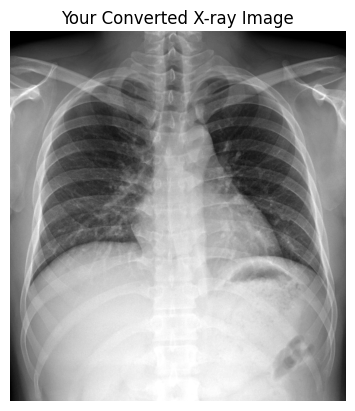

In [20]:
def dicom_to_jpeg(path,output):
    ds = pydicom.dcmread(path)
    img = ds.pixel_array.astype(float)
    p1, p99 = np.percentile(img, (1, 99))  # Remove outliers
    percentile_norm = np.clip((img - p1) / (p99 - p1) * 255, 0, 255).astype(np.uint8)
    Image.fromarray(percentile_norm).save(output,quality=95)

dicom_to_jpeg("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/002a34c58c5b758217ed1f584ccbcfe9.dicom","test1.jpg")
img = Image.open("/kaggle/working/test1.jpg")
plt.imshow(img, cmap='gray')  # gray colormap for X-rays
plt.title("Your Converted X-ray Image")
plt.axis('off')  # Remove axes
plt.show()

## DataSet Preparation

* Training Set : 3000 images
* Validation Set : 700 images

In [93]:
n= 1
for dirpath, dirnames, filenames in os.walk("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        # os.remove(file_path)
        if(n<=3000):
            jpeg_filename = os.path.splitext(filename)[0] + '.jpg'
            jpeg_path = os.path.join("/kaggle/working/train/images", jpeg_filename)
            dicom_to_jpeg(file_path,jpeg_path)
        else:
            break
        n+=1

In [103]:
n =1
for dirpath, dirnames, filenames in os.walk("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        if(n>4000 and n<=4700):
            jpeg_filename = os.path.splitext(filename)[0] + '.jpg'
            jpeg_path = os.path.join("/kaggle/working/val/images", jpeg_filename)
            dicom_to_jpeg(file_path,jpeg_path)
        elif(n>4700):
            break
        n+=1
        

In [31]:
df = pd.read_csv("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv")

In [105]:
for dirpath, dirnames, filenames in os.walk("/kaggle/working/train/images"):
    for filename in filenames:
        img = Image.open(f"/kaggle/working/train/images/{filename}")
        width, height = img.size
        jpeg_filename = os.path.splitext(filename)[0]
        rows = df[df["image_id"]==jpeg_filename]
        with open(f"/kaggle/working/train/labels/{jpeg_filename}.txt", "w") as f:
            f.write("")
        if rows["class_id"].iloc[0] != 14:
            rows = rows.sort_values(by = 'class_id',ascending = True)
            count = (df["image_id"]==jpeg_filename).sum()
            for i in range(0,count):
                text = str(rows["class_id"].iloc[i]) + " "
                x_cen = (rows["x_min"].iloc[i] + rows["x_max"].iloc[i])/2
                y_cen = (rows["y_min"].iloc[i] + rows["y_max"].iloc[i])/2
                wid = (rows["x_max"].iloc[i] - rows["x_min"].iloc[i])
                hei = (rows["y_max"].iloc[i] - rows["y_min"].iloc[i])
                norm_x = x_cen/width
                norm_y = y_cen/height
                norm_w = wid/width
                norm_h = hei/height
                text=text+str(norm_x)+" "+str(norm_y)+" "+str(norm_w)+" "+str(norm_h)+"\n"
                # print(text)
                with open(f"/kaggle/working/train/labels/{jpeg_filename}.txt", "a") as f:
                    f.write(text)

In [101]:
f = open("/kaggle/working/train/labels/00aca42a24e4ea6066cca2546150c36e.txt")
print(f.read())
f.close()

0 0.5595993322203673 0.30662983425414364 0.1001669449081803 0.11342216444588886
0 0.5545909849749583 0.30500487487812805 0.10684474123539232 0.10562235944101397
0 0.5570951585976628 0.3262918427039324 0.10851419031719532 0.13909652258693533
3 0.5651085141903172 0.6002599935001625 0.4003338898163606 0.12804679883002926
7 0.18864774624373956 0.48602534936626585 0.15225375626043405 0.3233669158271043
7 0.7884808013355593 0.601884952876178 0.10717863105175292 0.10334741631459214
10 0.8191986644407345 0.6394215144621385 0.06978297161936561 0.14397140071498213
11 0.3252086811352254 0.1286967825804355 0.10283806343906511 0.03964900877478063
11 0.7046744574290484 0.15485862853428664 0.07445742904841403 0.052973675658108545



In [106]:
for dirpath, dirnames, filenames in os.walk("/kaggle/working/val/images"):
    for filename in filenames:
        img = Image.open(os.path.join(dirpath,filename))
        width, height = img.size
        jpeg_filename = os.path.splitext(filename)[0]
        rows = df[df["image_id"]==jpeg_filename]
        with open(f"/kaggle/working/val/labels/{jpeg_filename}.txt", "w") as f:
            f.write("")
        if rows["class_id"].iloc[0] != 14:
            rows = rows.sort_values(by = 'class_id',ascending = True)
            count = (df["image_id"]==jpeg_filename).sum()
            for i in range(0,count):
                text = str(rows["class_id"].iloc[i]) + " "
                x_cen = (rows["x_min"].iloc[i] + rows["x_max"].iloc[i])/2
                y_cen = (rows["y_min"].iloc[i] + rows["y_max"].iloc[i])/2
                wid = (rows["x_max"].iloc[i] - rows["x_min"].iloc[i])
                hei = (rows["y_max"].iloc[i] - rows["y_min"].iloc[i])
                norm_x = x_cen/width
                norm_y = y_cen/height
                norm_w = wid/width
                norm_h = hei/height
                text=text+str(norm_x)+" "+str(norm_y)+" "+str(norm_w)+" "+str(norm_h)+"\n"
                # print(text)
                with open(f"/kaggle/working/val/labels/{jpeg_filename}.txt", "a") as f:
                    f.write(text)

In [107]:
f = open("/kaggle/working/val/labels/02cd1d17763c869ff3d4af5e28539456.txt")
print(f.read())
f.close()

0 0.544921875 0.3236111111111111 0.11675347222222222 0.11875
0 0.5342881944444444 0.32447916666666665 0.14322916666666666 0.13090277777777778
0 0.5349392361111112 0.3076388888888889 0.11588541666666667 0.0763888888888889
3 0.5167100694444444 0.5067708333333333 0.3962673611111111 0.115625
3 0.5164930555555556 0.5222222222222223 0.390625 0.10138888888888889
3 0.5221354166666666 0.5178819444444445 0.3880208333333333 0.09479166666666666
10 0.11805555555555555 0.5670138888888889 0.04600694444444445 0.11458333333333333
10 0.7662760416666666 0.5809027777777778 0.047309027777777776 0.10833333333333334
11 0.283203125 0.14756944444444445 0.0915798611111111 0.04652777777777778
11 0.11805555555555555 0.5670138888888889 0.04600694444444445 0.11458333333333333
11 0.2688802083333333 0.14704861111111112 0.062065972222222224 0.03715277777777778
11 0.7662760416666666 0.5809027777777778 0.047309027777777776 0.10833333333333334



YAML file for YOLO

In [108]:
import yaml

# Your dataset configuration
config = {
    'train': '../train/images',
    'val': '../val/images',
    'nc': 14,
    'names': {0: 'Aortic enlargement', 1: 'Atelectasis', 2:'Calcification', 3:'Cardiomegaly', 4:'Consolidation',5:'ILD',6:'Infiltration',7:'Lung Opacity',8:'Nodule/Mass',9:'Other lesion',10:'Pleural effusion',11:'Pleural thickening', 12:'Pneumothorax', 13:'Pulmonary fibrosis'}
}

# Write to file
with open('data.yaml', 'w') as f:
    yaml.dump(config, f, default_flow_style=False,sort_keys=False)

In [109]:
f = open("/kaggle/working/data.yaml","r")
print(f.read())
f.close()

train: ../train/images
val: ../val/images
nc: 14
names:
  0: Aortic enlargement
  1: Atelectasis
  2: Calcification
  3: Cardiomegaly
  4: Consolidation
  5: ILD
  6: Infiltration
  7: Lung Opacity
  8: Nodule/Mass
  9: Other lesion
  10: Pleural effusion
  11: Pleural thickening
  12: Pneumothorax
  13: Pulmonary fibrosis



## Training the YOLO v11 model

* epochs : 100
* image size : 640
* batch size : 16
* Multiple GPU used for training

In [ ]:
results = model.train(data="data.yaml", epochs=100, imgsz=640,batch=16,device="0,1")

Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train22, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tru

train: Scanning /kaggle/working/train/labels... 3000 images, 2120 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:01<00:00, 1715.94it/s]


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2569.9±1774.2 MB/s, size: 1267.5 KB)


val: Scanning /kaggle/working/val/labels... 700 images, 503 backgrounds, 0 corrupt: 100%|██████████| 700/700 [00:00<00:00, 2238.12it/s]


val: New cache created: /kaggle/working/val/labels.cache
Plotting labels to runs/detect/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train22
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.25G      2.226      6.059      2.098         13        640: 100%|██████████| 188/188 [01:32<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:18<00:00,  2.43it/s]


                   all        700       1524      0.683      0.051     0.0305     0.0152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.57G       2.23      4.069      2.053          3        640: 100%|██████████| 188/188 [01:28<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.50it/s]


                   all        700       1524      0.729     0.0352     0.0182    0.00745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.63G      2.129      3.993      2.028         15        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


                   all        700       1524      0.616     0.0184     0.0188     0.0085

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.65G      2.094      3.355      2.043          9        640: 100%|██████████| 188/188 [01:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.63it/s]


                   all        700       1524      0.326     0.0537     0.0234     0.0121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       5.7G      2.075      3.428      1.973         32        640: 100%|██████████| 188/188 [01:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.57it/s]


                   all        700       1524     0.0273      0.172     0.0499     0.0221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       5.7G      1.983      3.051      1.899         24        640: 100%|██████████| 188/188 [01:25<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.59it/s]


                   all        700       1524      0.506     0.0962     0.0697     0.0318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       5.7G      1.999      2.996      1.928         16        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.68it/s]


                   all        700       1524      0.745     0.0396     0.0679     0.0342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       5.7G      1.935      3.082      1.859         22        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.65it/s]


                   all        700       1524      0.646      0.109      0.091     0.0473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.71G      1.925      3.055       1.87          5        640: 100%|██████████| 188/188 [01:25<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.62it/s]


                   all        700       1524      0.614      0.115      0.104     0.0485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.76G      1.937      2.915      1.846         15        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.61it/s]


                   all        700       1524      0.731     0.0475     0.0833     0.0414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.76G      1.817      2.624      1.791          4        640: 100%|██████████| 188/188 [01:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.64it/s]


                   all        700       1524      0.682      0.073     0.0698     0.0345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.76G      1.817      2.729      1.801         29        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.70it/s]


                   all        700       1524      0.583      0.112      0.096      0.045

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.76G      1.864      2.699      1.816         25        640: 100%|██████████| 188/188 [01:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.64it/s]


                   all        700       1524      0.608     0.0923     0.0989     0.0467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.76G      1.863      2.813      1.828         23        640: 100%|██████████| 188/188 [01:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]


                   all        700       1524      0.589     0.0953        0.1     0.0503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.76G      1.757      2.832       1.73         17        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]


                   all        700       1524      0.614      0.102      0.114     0.0554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.76G       1.82       2.72      1.798          0        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.58it/s]


                   all        700       1524      0.335      0.118      0.111     0.0546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.76G      1.758       2.67       1.77         15        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.63it/s]


                   all        700       1524      0.473      0.121     0.0994     0.0472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.76G       1.75      2.664      1.737          3        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.70it/s]


                   all        700       1524      0.391      0.118      0.113     0.0565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.76G      1.804      2.547      1.779         26        640: 100%|██████████| 188/188 [01:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.59it/s]


                   all        700       1524      0.358      0.161      0.125     0.0637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.76G      1.796      2.897      1.755         15        640: 100%|██████████| 188/188 [01:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524      0.373      0.119      0.114     0.0572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.76G      1.768      2.649      1.734         15        640: 100%|██████████| 188/188 [01:25<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.65it/s]


                   all        700       1524      0.425      0.157      0.139     0.0691


  0%|          | 0/188 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.76G      1.777      2.546       1.76         21        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.62it/s]


                   all        700       1524      0.326      0.161      0.107     0.0544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.76G       1.75      2.516      1.747         41        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524      0.343      0.161      0.128     0.0637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.76G      1.775      2.568      1.766          5        640: 100%|██████████| 188/188 [01:23<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]


                   all        700       1524       0.29      0.179      0.141       0.07

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.76G      1.759      2.466      1.733         25        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524      0.266      0.161      0.136     0.0674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.76G      1.725      2.418      1.721         25        640: 100%|██████████| 188/188 [01:23<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524      0.316      0.181      0.151     0.0689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.76G       1.73      2.627       1.73         33        640: 100%|██████████| 188/188 [01:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.70it/s]


                   all        700       1524      0.259       0.18      0.139     0.0702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.76G      1.731      2.426      1.737         39        640: 100%|██████████| 188/188 [01:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.57it/s]


                   all        700       1524      0.356      0.185      0.146     0.0737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.76G      1.674      2.288      1.687         17        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.68it/s]


                   all        700       1524      0.302      0.177       0.15     0.0728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.76G      1.708      2.438      1.698         16        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.73it/s]


                   all        700       1524      0.288      0.197      0.145     0.0713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.76G      1.729      2.509      1.691          5        640: 100%|██████████| 188/188 [01:23<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.65it/s]


                   all        700       1524      0.255      0.181      0.145      0.068

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.76G       1.72      2.291      1.718         16        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.68it/s]


                   all        700       1524      0.291      0.195      0.151     0.0729


  0%|          | 0/188 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.76G       1.67      2.598      1.701         28        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.69it/s]


                   all        700       1524      0.305      0.157      0.158     0.0769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.76G      1.691      2.831      1.693         22        640: 100%|██████████| 188/188 [01:23<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524       0.31      0.198       0.17     0.0846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.76G      1.671      2.348      1.664         26        640: 100%|██████████| 188/188 [01:23<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.63it/s]


                   all        700       1524      0.279      0.189      0.155     0.0783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.76G      1.667      2.509      1.646          7        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.65it/s]


                   all        700       1524      0.369      0.186      0.151     0.0754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.76G       1.65      2.272      1.663         15        640: 100%|██████████| 188/188 [01:25<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.65it/s]


                   all        700       1524      0.334      0.195      0.156      0.078

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.76G      1.627      2.129      1.648         20        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.65it/s]


                   all        700       1524      0.283       0.23      0.164     0.0826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.78G      1.637      2.169      1.637          9        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.64it/s]


                   all        700       1524      0.322      0.157      0.152     0.0748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.78G      1.698      2.266      1.689         13        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.64it/s]


                   all        700       1524      0.272      0.177      0.169     0.0833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.78G       1.61      2.519      1.603         18        640: 100%|██████████| 188/188 [01:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524      0.365      0.139      0.143      0.074

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.78G      1.616      2.088      1.652         22        640: 100%|██████████| 188/188 [01:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.63it/s]


                   all        700       1524      0.338      0.232      0.187     0.0893


  0%|          | 0/188 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.78G      1.679      2.301      1.664         23        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.64it/s]


                   all        700       1524      0.267      0.192       0.17     0.0857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.83G      1.635      2.202      1.636         34        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.70it/s]


                   all        700       1524      0.334      0.198      0.178     0.0858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.83G      1.592       2.17      1.591         28        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.68it/s]


                   all        700       1524      0.306      0.203      0.176      0.084

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.83G      1.633      2.077      1.613          8        640: 100%|██████████| 188/188 [01:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.69it/s]


                   all        700       1524       0.34       0.22      0.178     0.0871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.83G      1.602      2.089      1.624          6        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.63it/s]


                   all        700       1524      0.253      0.195      0.175     0.0845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.83G      1.652      2.104      1.655         13        640: 100%|██████████| 188/188 [01:23<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.63it/s]


                   all        700       1524      0.266      0.205      0.173      0.085

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.83G      1.654      2.105       1.65          5        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.64it/s]


                   all        700       1524      0.293      0.215      0.194     0.0913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.83G      1.635      2.072      1.629         33        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.62it/s]


                   all        700       1524      0.267      0.218      0.181     0.0884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.83G      1.623      2.233        1.6         23        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.70it/s]


                   all        700       1524      0.223      0.206      0.172     0.0863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.83G       1.63      2.188      1.641         10        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.71it/s]


                   all        700       1524      0.249      0.209      0.185      0.091

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.83G      1.599       2.04       1.61         26        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.68it/s]


                   all        700       1524      0.216      0.211       0.18     0.0874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.83G       1.55      2.031      1.547         28        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.68it/s]


                   all        700       1524      0.212      0.232      0.189     0.0901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.83G      1.593      2.001      1.621          5        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.57it/s]


                   all        700       1524      0.286       0.22      0.205     0.0989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.83G      1.583      2.133      1.573          3        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.68it/s]


                   all        700       1524      0.261      0.241      0.201     0.0968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.83G      1.597      2.054      1.628          4        640: 100%|██████████| 188/188 [01:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.64it/s]


                   all        700       1524      0.242      0.221      0.197     0.0959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.83G      1.564      2.017      1.594          7        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.59it/s]


                   all        700       1524      0.236      0.226      0.189     0.0943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.83G      1.615      2.026      1.608          7        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.63it/s]


                   all        700       1524      0.277      0.236      0.204     0.0956

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.83G      1.572      2.059      1.569         23        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.56it/s]


                   all        700       1524      0.236      0.194      0.166     0.0831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.83G      1.572      2.009        1.6         26        640: 100%|██████████| 188/188 [01:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524      0.275      0.241      0.207      0.099

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.83G      1.529      1.881      1.559          5        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.62it/s]


                   all        700       1524      0.303      0.234      0.191      0.092

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.83G      1.494      1.886       1.52         18        640: 100%|██████████| 188/188 [01:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]


                   all        700       1524       0.25      0.211       0.19     0.0949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.83G      1.574      2.023       1.57         23        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.62it/s]


                   all        700       1524      0.269      0.228      0.203     0.0984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.83G      1.544      1.893      1.572         12        640: 100%|██████████| 188/188 [01:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]


                   all        700       1524      0.348      0.245       0.21      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.83G      1.522      1.845      1.521          9        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.58it/s]


                   all        700       1524      0.349       0.23       0.21      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.83G      1.534      1.973      1.509          9        640: 100%|██████████| 188/188 [01:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.65it/s]


                   all        700       1524       0.26      0.231      0.203      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.83G      1.547      1.978      1.537         40        640: 100%|██████████| 188/188 [01:23<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


                   all        700       1524       0.29      0.247      0.218      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.83G      1.506      1.969      1.534         21        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.70it/s]


                   all        700       1524       0.26      0.216      0.203     0.0956

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.83G      1.511      1.813       1.54          3        640: 100%|██████████| 188/188 [01:23<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524      0.278      0.236      0.195     0.0995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.83G      1.516      2.022      1.525         15        640: 100%|██████████| 188/188 [01:22<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.59it/s]


                   all        700       1524      0.264      0.218      0.199      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.83G        1.5       1.69      1.546         33        640:  37%|███▋      | 69/188 [00:30<00:50,  2.37it/s]

In [6]:
tr_model = YOLO("/kaggle/working/runs/detect/train22/weights/last.pt")
tr_results = tr_model.train(resume = True)

Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/runs/detect/train22/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train22, nbs=64, nms=False, opset=None, optimiz

DDP: debug command /usr/bin/python3 -m torch.distributed.run --nproc_per_node 2 --master_port 49685 /root/.config/Ultralytics/DDP/_temp_0g1_nt7m135256163564496.py
Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
Transferred 649/649 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4152.0±992.3 MB/s, size: 1145.4 KB)


train: Scanning /kaggle/working/train/labels.cache... 3000 images, 2120 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1455.5±1700.6 MB/s, size: 1267.5 KB)


val: Scanning /kaggle/working/val/labels.cache... 700 images, 503 backgrounds, 0 corrupt: 100%|██████████| 700/700 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Resuming training /kaggle/working/runs/detect/train22/weights/last.pt from epoch 77 to 100 total epochs
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train22
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.33G      1.493      1.872      1.548         13        640: 100%|██████████| 188/188 [01:29<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:17<00:00,  2.47it/s]


                   all        700       1524      0.268      0.235      0.205      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.66G      1.531       1.76      1.536          3        640: 100%|██████████| 188/188 [01:26<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.61it/s]


                   all        700       1524      0.304      0.238      0.214      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.72G      1.486      1.811      1.558          8        640: 100%|██████████| 188/188 [01:25<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.61it/s]


                   all        700       1524      0.294      0.233      0.217       0.11


  0%|          | 0/188 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.79G      1.469      1.722      1.537         31        640: 100%|██████████| 188/188 [01:25<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.60it/s]


                   all        700       1524      0.262      0.234      0.209      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.84G      1.512      1.775      1.554         57        640: 100%|██████████| 188/188 [01:25<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]


                   all        700       1524      0.279       0.25      0.216      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.84G      1.498      1.797      1.536         12        640: 100%|██████████| 188/188 [01:25<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.65it/s]


                   all        700       1524      0.282      0.231      0.215      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.84G      1.498      1.784      1.541          0        640: 100%|██████████| 188/188 [01:25<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.65it/s]


                   all        700       1524      0.273      0.236      0.214      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.84G       1.45      1.707      1.505         12        640: 100%|██████████| 188/188 [01:25<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.59it/s]


                   all        700       1524      0.303      0.245      0.221      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.84G       1.46      1.647      1.513          9        640: 100%|██████████| 188/188 [01:25<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.61it/s]


                   all        700       1524      0.308      0.247      0.229      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.84G      1.436      1.758      1.514          4        640: 100%|██████████| 188/188 [01:26<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]


                   all        700       1524      0.287      0.231      0.218      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.84G      1.437      1.654        1.5         47        640: 100%|██████████| 188/188 [01:25<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.69it/s]


                   all        700       1524      0.265      0.228      0.206      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.84G      1.459      1.663      1.502          8        640: 100%|██████████| 188/188 [01:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.68it/s]


                   all        700       1524      0.298      0.242      0.214      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.84G      1.444      1.714      1.497         19        640: 100%|██████████| 188/188 [01:25<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524      0.292      0.234      0.219      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.84G      1.425      1.643      1.483         54        640: 100%|██████████| 188/188 [01:25<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524      0.274      0.242      0.219      0.109
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.84G       1.37      1.559      1.489         19        640: 100%|██████████| 188/188 [01:25<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.63it/s]


                   all        700       1524       0.29       0.23      0.205      0.103


  0%|          | 0/188 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.84G      1.363      1.508      1.494         19        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]


                   all        700       1524       0.31      0.236      0.221      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.84G      1.311      1.395      1.443          0        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.60it/s]


                   all        700       1524      0.358      0.231      0.212      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.84G      1.347      1.486      1.479         33        640: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.68it/s]


                   all        700       1524      0.382      0.252       0.22       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.84G      1.326      1.444      1.468          7        640: 100%|██████████| 188/188 [01:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524      0.311      0.249      0.221      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.84G      1.311      1.545      1.443         16        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.62it/s]


                   all        700       1524      0.302      0.246      0.224      0.113


  0%|          | 0/188 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.84G      1.325       1.45      1.469          0        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.60it/s]


                   all        700       1524      0.298      0.238      0.218      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.84G      1.321      1.442      1.442         16        640: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]


                   all        700       1524      0.282      0.243      0.215       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.84G      1.334        1.4      1.473          0        640: 100%|██████████| 188/188 [01:23<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


                   all        700       1524      0.306      0.242       0.22      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.84G      1.293      1.364      1.451         10        640: 100%|██████████| 188/188 [01:23<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.61it/s]


                   all        700       1524      0.322      0.235       0.22      0.113

24 epochs completed in 0.687 hours.
Optimizer stripped from runs/detect/train22/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train22/weights/best.pt, 40.5MB

Validating runs/detect/train22/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,040,826 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:16<00:00,  2.62it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        700       1524      0.308      0.246      0.229      0.112
    Aortic enlargement        138        331      0.613      0.546      0.604      0.367
           Atelectasis          9         15      0.382      0.207      0.394      0.197
         Calcification         22         53      0.293     0.0755      0.079     0.0224
          Cardiomegaly        104        245      0.728      0.515       0.61      0.399
         Consolidation         13         18      0.361      0.278      0.301       0.13
                   ILD         12         28      0.136      0.107     0.0456      0.017
          Infiltration         26         60      0.405      0.183       0.18     0.0694
          Lung Opacity         59        101      0.176      0.158     0.0758     0.0246
           Nodule/Mass         36         76       0.29      0.158      0.106     0.0382
          Other lesion         45         85      0.146     0.0941     0.0337    0.00863
      Pleural effusio

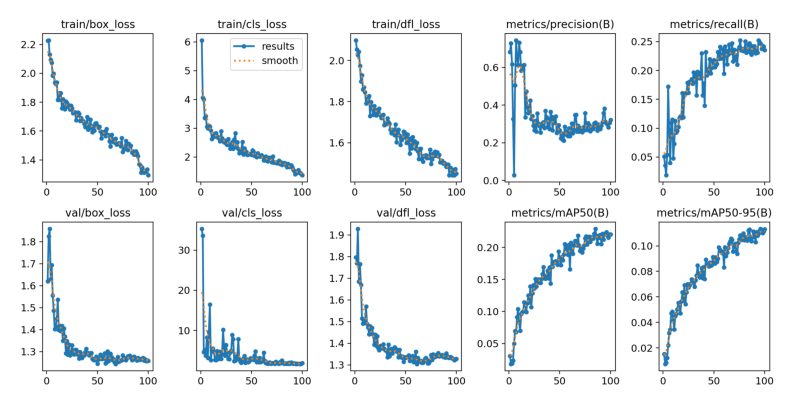

In [16]:
img = Image.open("/kaggle/working/runs/detect/train22/results.png")
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis("off")
plt.show()

## Inference Running on Unseen Data

In [18]:
x_ray_model = YOLO("/kaggle/working/runs/detect/train22/weights/best.pt")

In [105]:
def show_bbimg(path,filename,ax):
    img = Image.open(path)
    ax.imshow(img,cmap='gray')
    rows = df[df["image_id"]==filename]
    if rows["class_id"].iloc[0] != 14:
        dic={}
        rows = rows.sort_values(by = 'class_id',ascending = True)
        count = (df["image_id"]==filename).sum()
        for i in range(0,count):
            wid = (rows["x_max"].iloc[i] - rows["x_min"].iloc[i])
            hei = (rows["y_max"].iloc[i] - rows["y_min"].iloc[i])
            label = rows["class_name"].iloc[i]
            rect = patches.Rectangle((rows["x_min"].iloc[i], rows["y_min"].iloc[i]), wid, hei, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.text(rows["x_min"].iloc[i], rows["y_min"].iloc[i] - 5, str(label), color="white", fontsize=10,
                    bbox=dict(facecolor="red", alpha=0.5, edgecolor="none", boxstyle="round,pad=0.2"))
            if label in dic:
                dic[label]+=1
            else:
                dic[label] = 1
    print("Ground Truth",dic)
    ax.axis("off")

In [21]:
dicom_to_jpeg("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/009d837e29ba400e03856cf8d6a5b545.dicom","/kaggle/working/test2.jpg")

In [30]:
results=x_ray_model("test2.jpg")


image 1/1 /kaggle/working/test2.jpg: 640x512 1 Aortic enlargement, 28.5ms
Speed: 3.6ms preprocess, 28.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


Ground Truth {'Aortic enlargement': 2, 'Pleural thickening': 1}


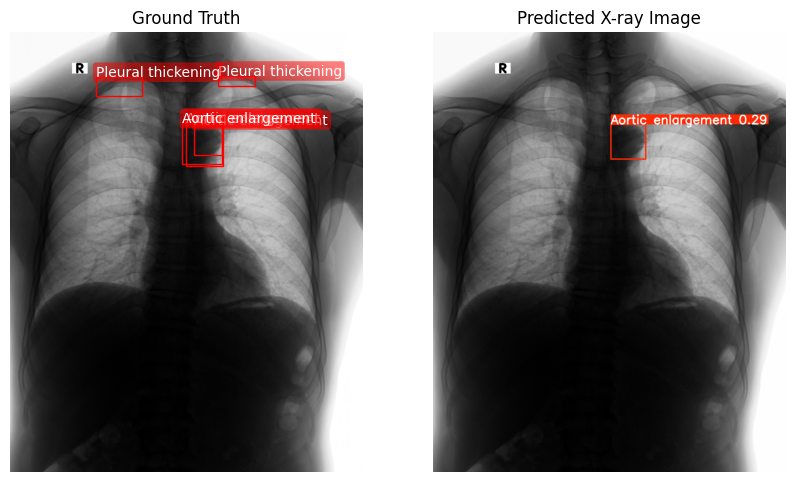

In [103]:
fig, ax = plt.subplots(1,2,figsize=(10,8))
show_bbimg("/kaggle/working/test2.jpg","009d837e29ba400e03856cf8d6a5b545",ax[0])
ax[0].set_title("Ground Truth")
ax[1].set_title("Predicted X-ray Image")
ax[1].imshow(results[0].plot())
ax[1].axis('off') 
plt.show()


image 1/1 /kaggle/working/test3.jpg: 640x544 1 Aortic enlargement, 1 Lung Opacity, 2 Other lesions, 5 Pleural effusions, 3 Pleural thickenings, 6 Pulmonary fibrosiss, 36.0ms
Speed: 3.0ms preprocess, 36.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)
Ground Truth {'Atelectasis': 2, 'Consolidation': 2, 'Lung Opacity': 1, 'Pleural effusion': 6, 'Pleural thickening': 6, 'Pulmonary fibrosis': 6}


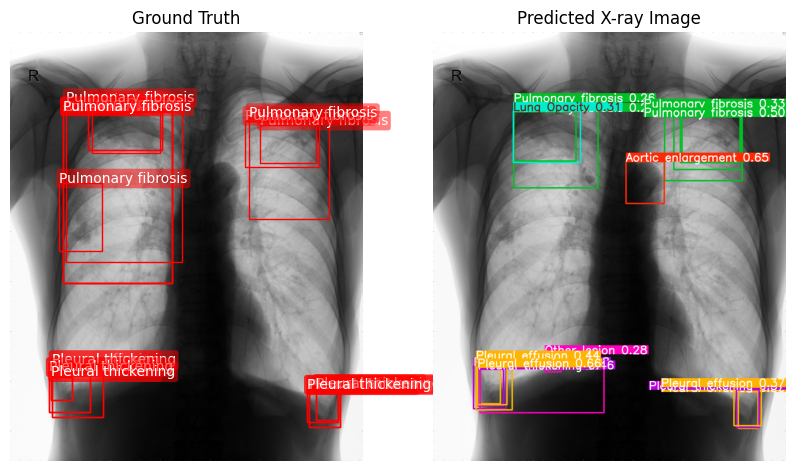

In [106]:
img_id="ff924bcbd38f123aec723aa7040d7e43"
filepath=f"/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/{img_id}.dicom"
jpg_path = "/kaggle/working/test3.jpg"

dicom_to_jpeg(filepath,jpg_path)
res2=x_ray_model(jpg_path)
fig, ax = plt.subplots(1,2,figsize=(10,8))
show_bbimg(jpg_path,img_id,ax[0])
ax[0].set_title("Ground Truth")
ax[1].set_title("Predicted X-ray Image")
ax[1].imshow(res2[0].plot())
ax[1].axis('off') 
plt.show()


image 1/1 /kaggle/working/test4.jpg: 640x512 2 Aortic enlargements, 1 Cardiomegaly, 28.5ms
Speed: 3.1ms preprocess, 28.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)
Ground Truth {'Aortic enlargement': 3, 'Cardiomegaly': 3}


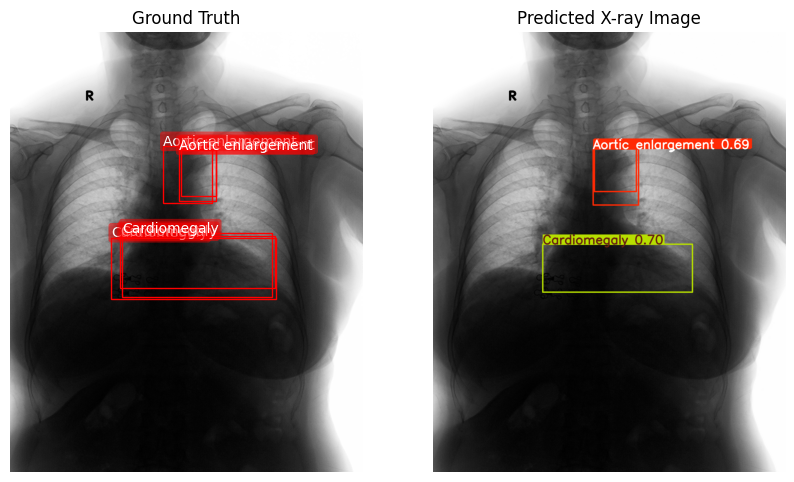

In [109]:
img_id="f9dda1a40ac162af4e9fbc6027ed5375"
filepath=f"/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/{img_id}.dicom"
jpg_path = "/kaggle/working/test4.jpg"

dicom_to_jpeg(filepath,jpg_path)
res=x_ray_model(jpg_path)
fig, ax = plt.subplots(1,2,figsize=(10,8))
show_bbimg(jpg_path,img_id,ax[0])
ax[0].set_title("Ground Truth")
ax[1].set_title("Predicted X-ray Image")
ax[1].imshow(res[0].plot())
ax[1].axis('off') 
plt.show()

In [112]:
metrics = x_ray_model.val(data="data.yaml", split="val")
print(metrics) 

Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4816.5±1204.0 MB/s, size: 1452.5 KB)


val: Scanning /kaggle/working/val/labels.cache... 700 images, 503 backgrounds, 0 corrupt: 100%|██████████| 700/700 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:20<00:00,  2.13it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        700       1524      0.306      0.244      0.229      0.113
    Aortic enlargement        138        331      0.614      0.548        0.6      0.366
           Atelectasis          9         15       0.38      0.204      0.393      0.199
         Calcification         22         53      0.293     0.0755     0.0727     0.0219
          Cardiomegaly        104        245      0.721      0.507      0.611        0.4
         Consolidation         13         18      0.359      0.278      0.302       0.13
                   ILD         12         28      0.141      0.107     0.0457     0.0167
          Infiltration         26         60      0.408      0.183      0.179     0.0681
          Lung Opacity         59        101      0.168      0.152     0.0755     0.0246
           Nodule/Mass         36         76      0.284      0.158      0.107     0.0399
          Other lesion         45         85      0.152     0.0941     0.0344    0.00921
      Pleural effusio

In [125]:
print("mAP@0.5:", metrics.box.map50) 
print("mAP@0.5:0.95:", metrics.box.map) 

mAP@0.5: 0.2285363532176138
mAP@0.5:0.95: 0.11292549127391674


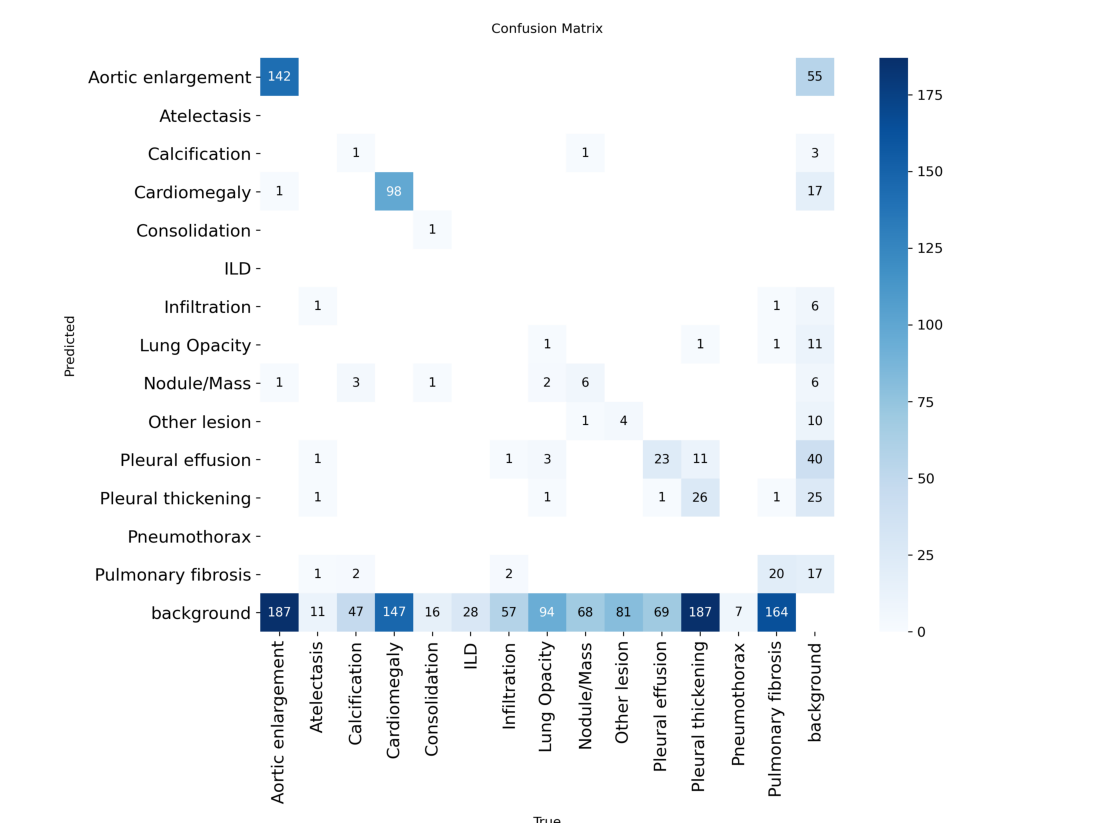

In [124]:
img = Image.open("runs/detect/val/confusion_matrix.png")
plt.figure(figsize=(14,14))
plt.imshow(img)
plt.axis("off")
plt.show()